In [1]:
import numpy as np
from PIL import Image as im
from PIL import ImageOps as imo
from numpy.lib.stride_tricks import sliding_window_view

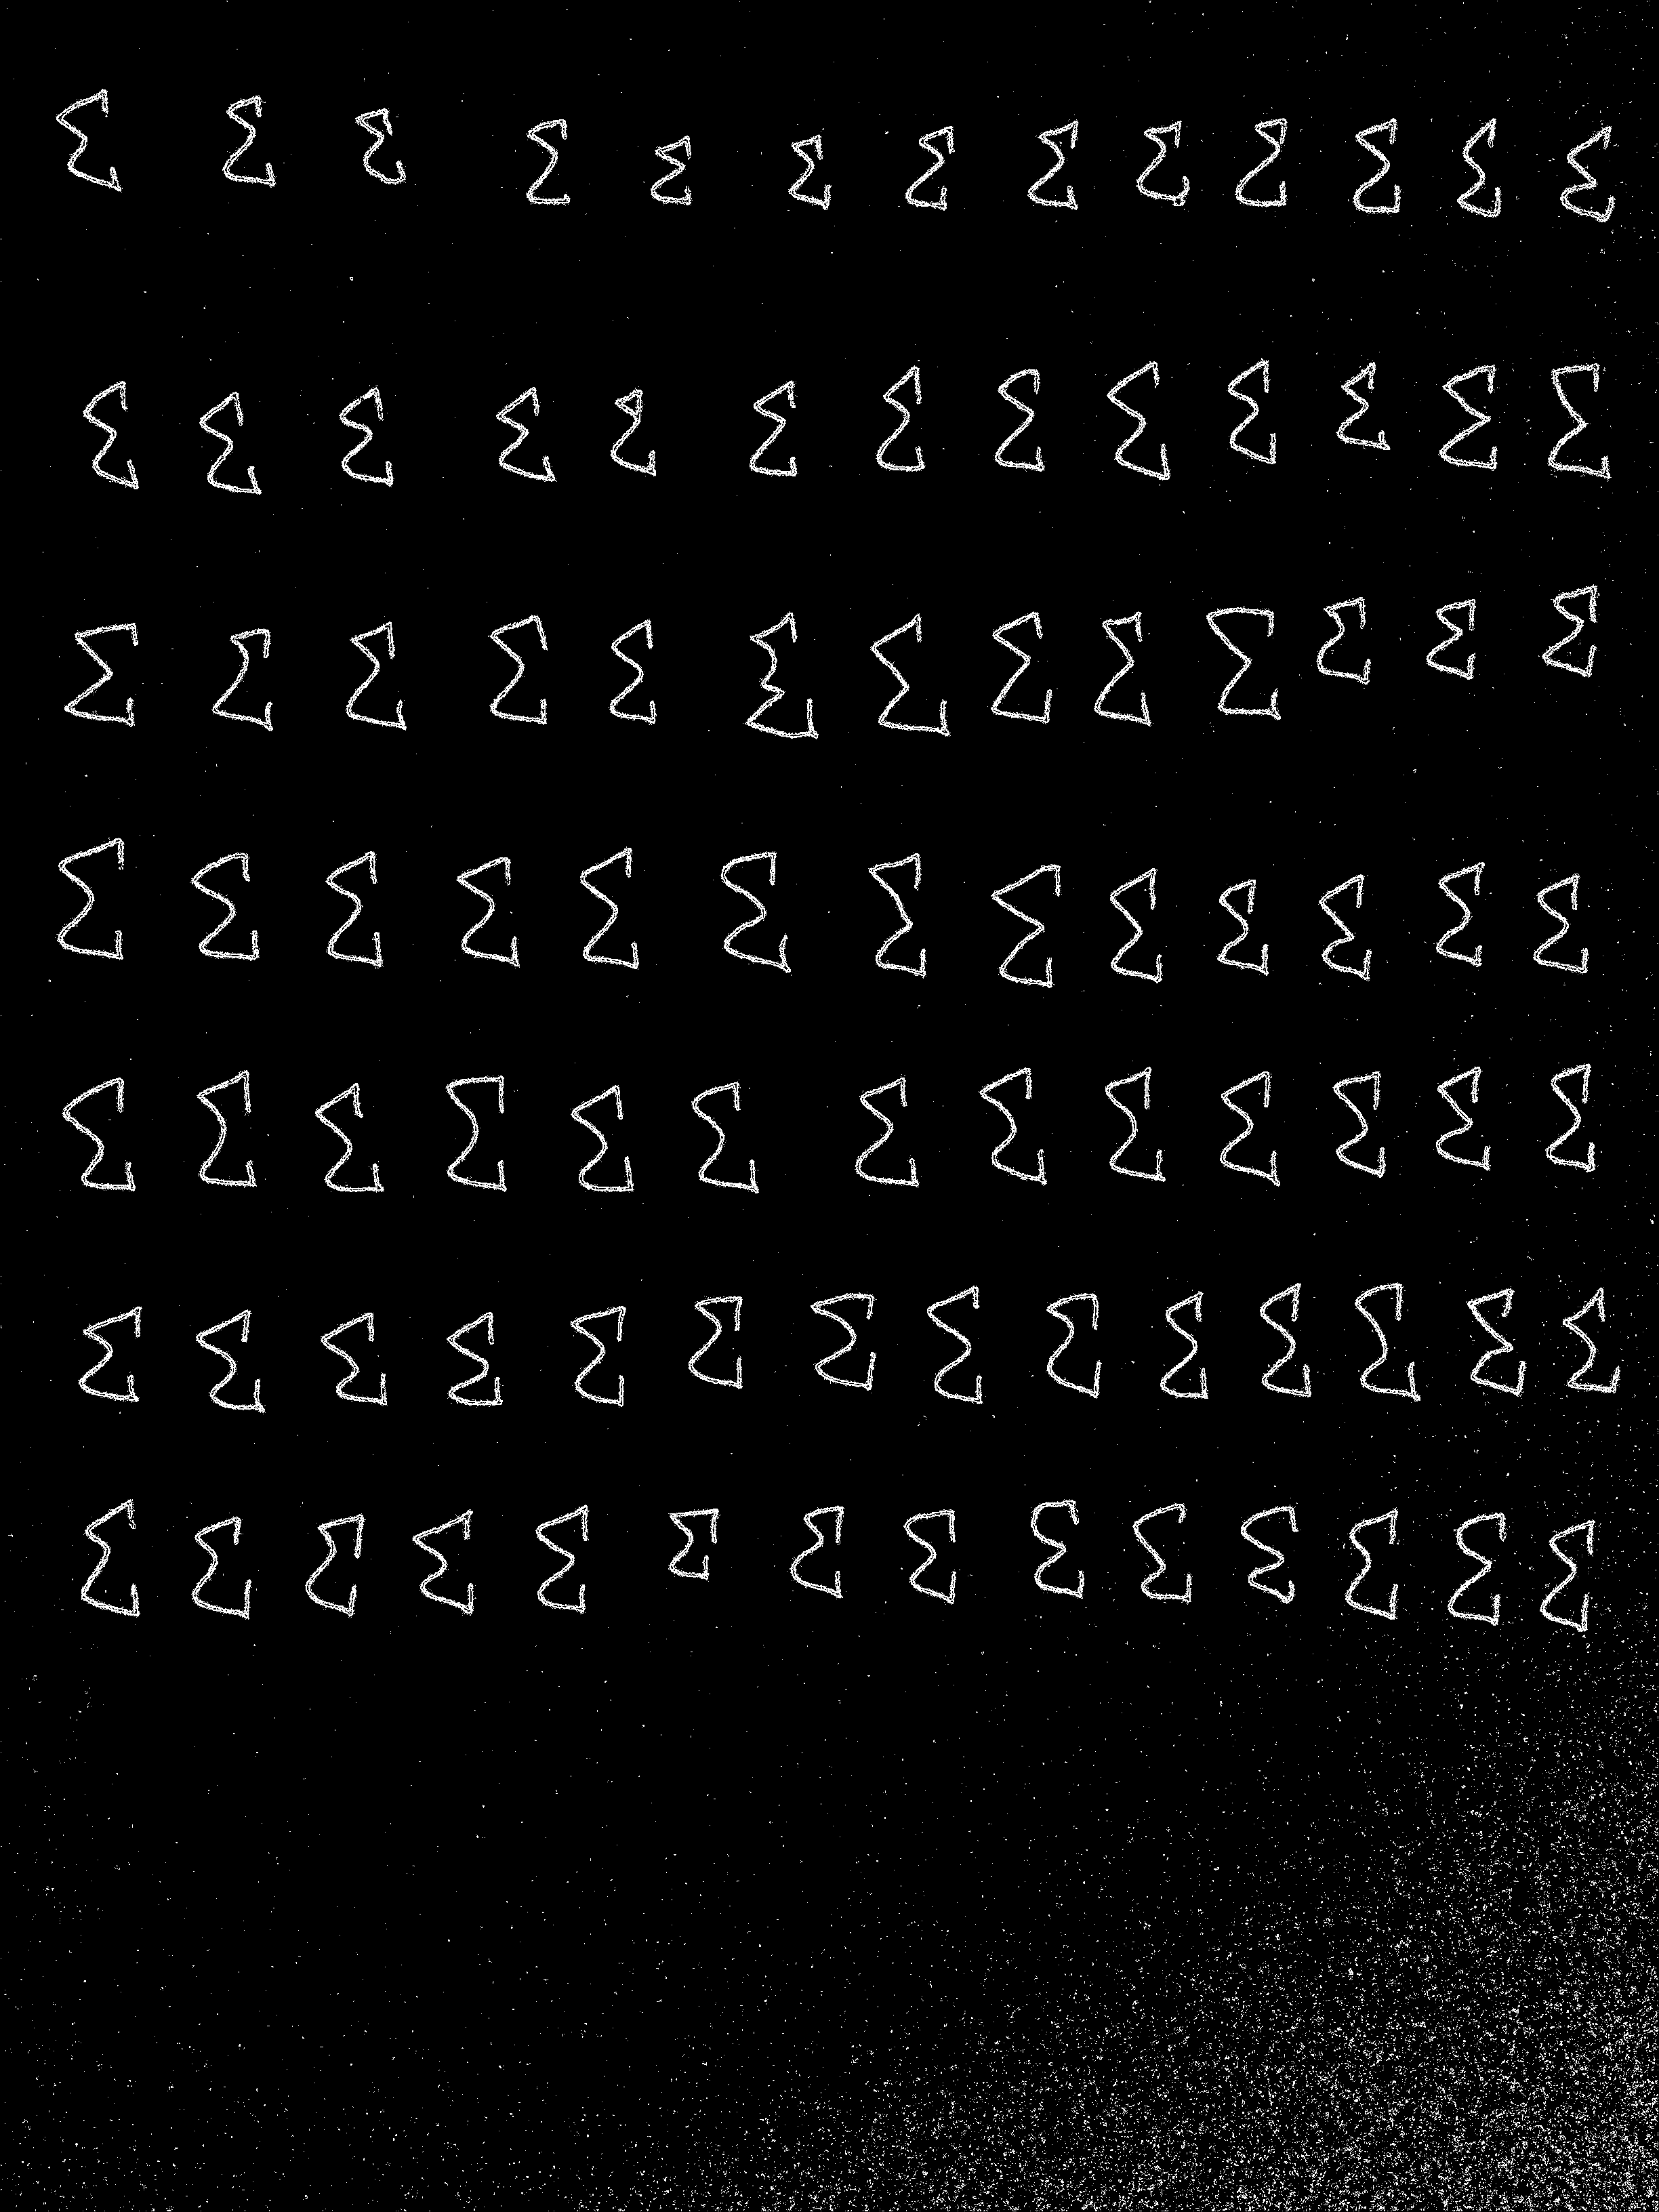

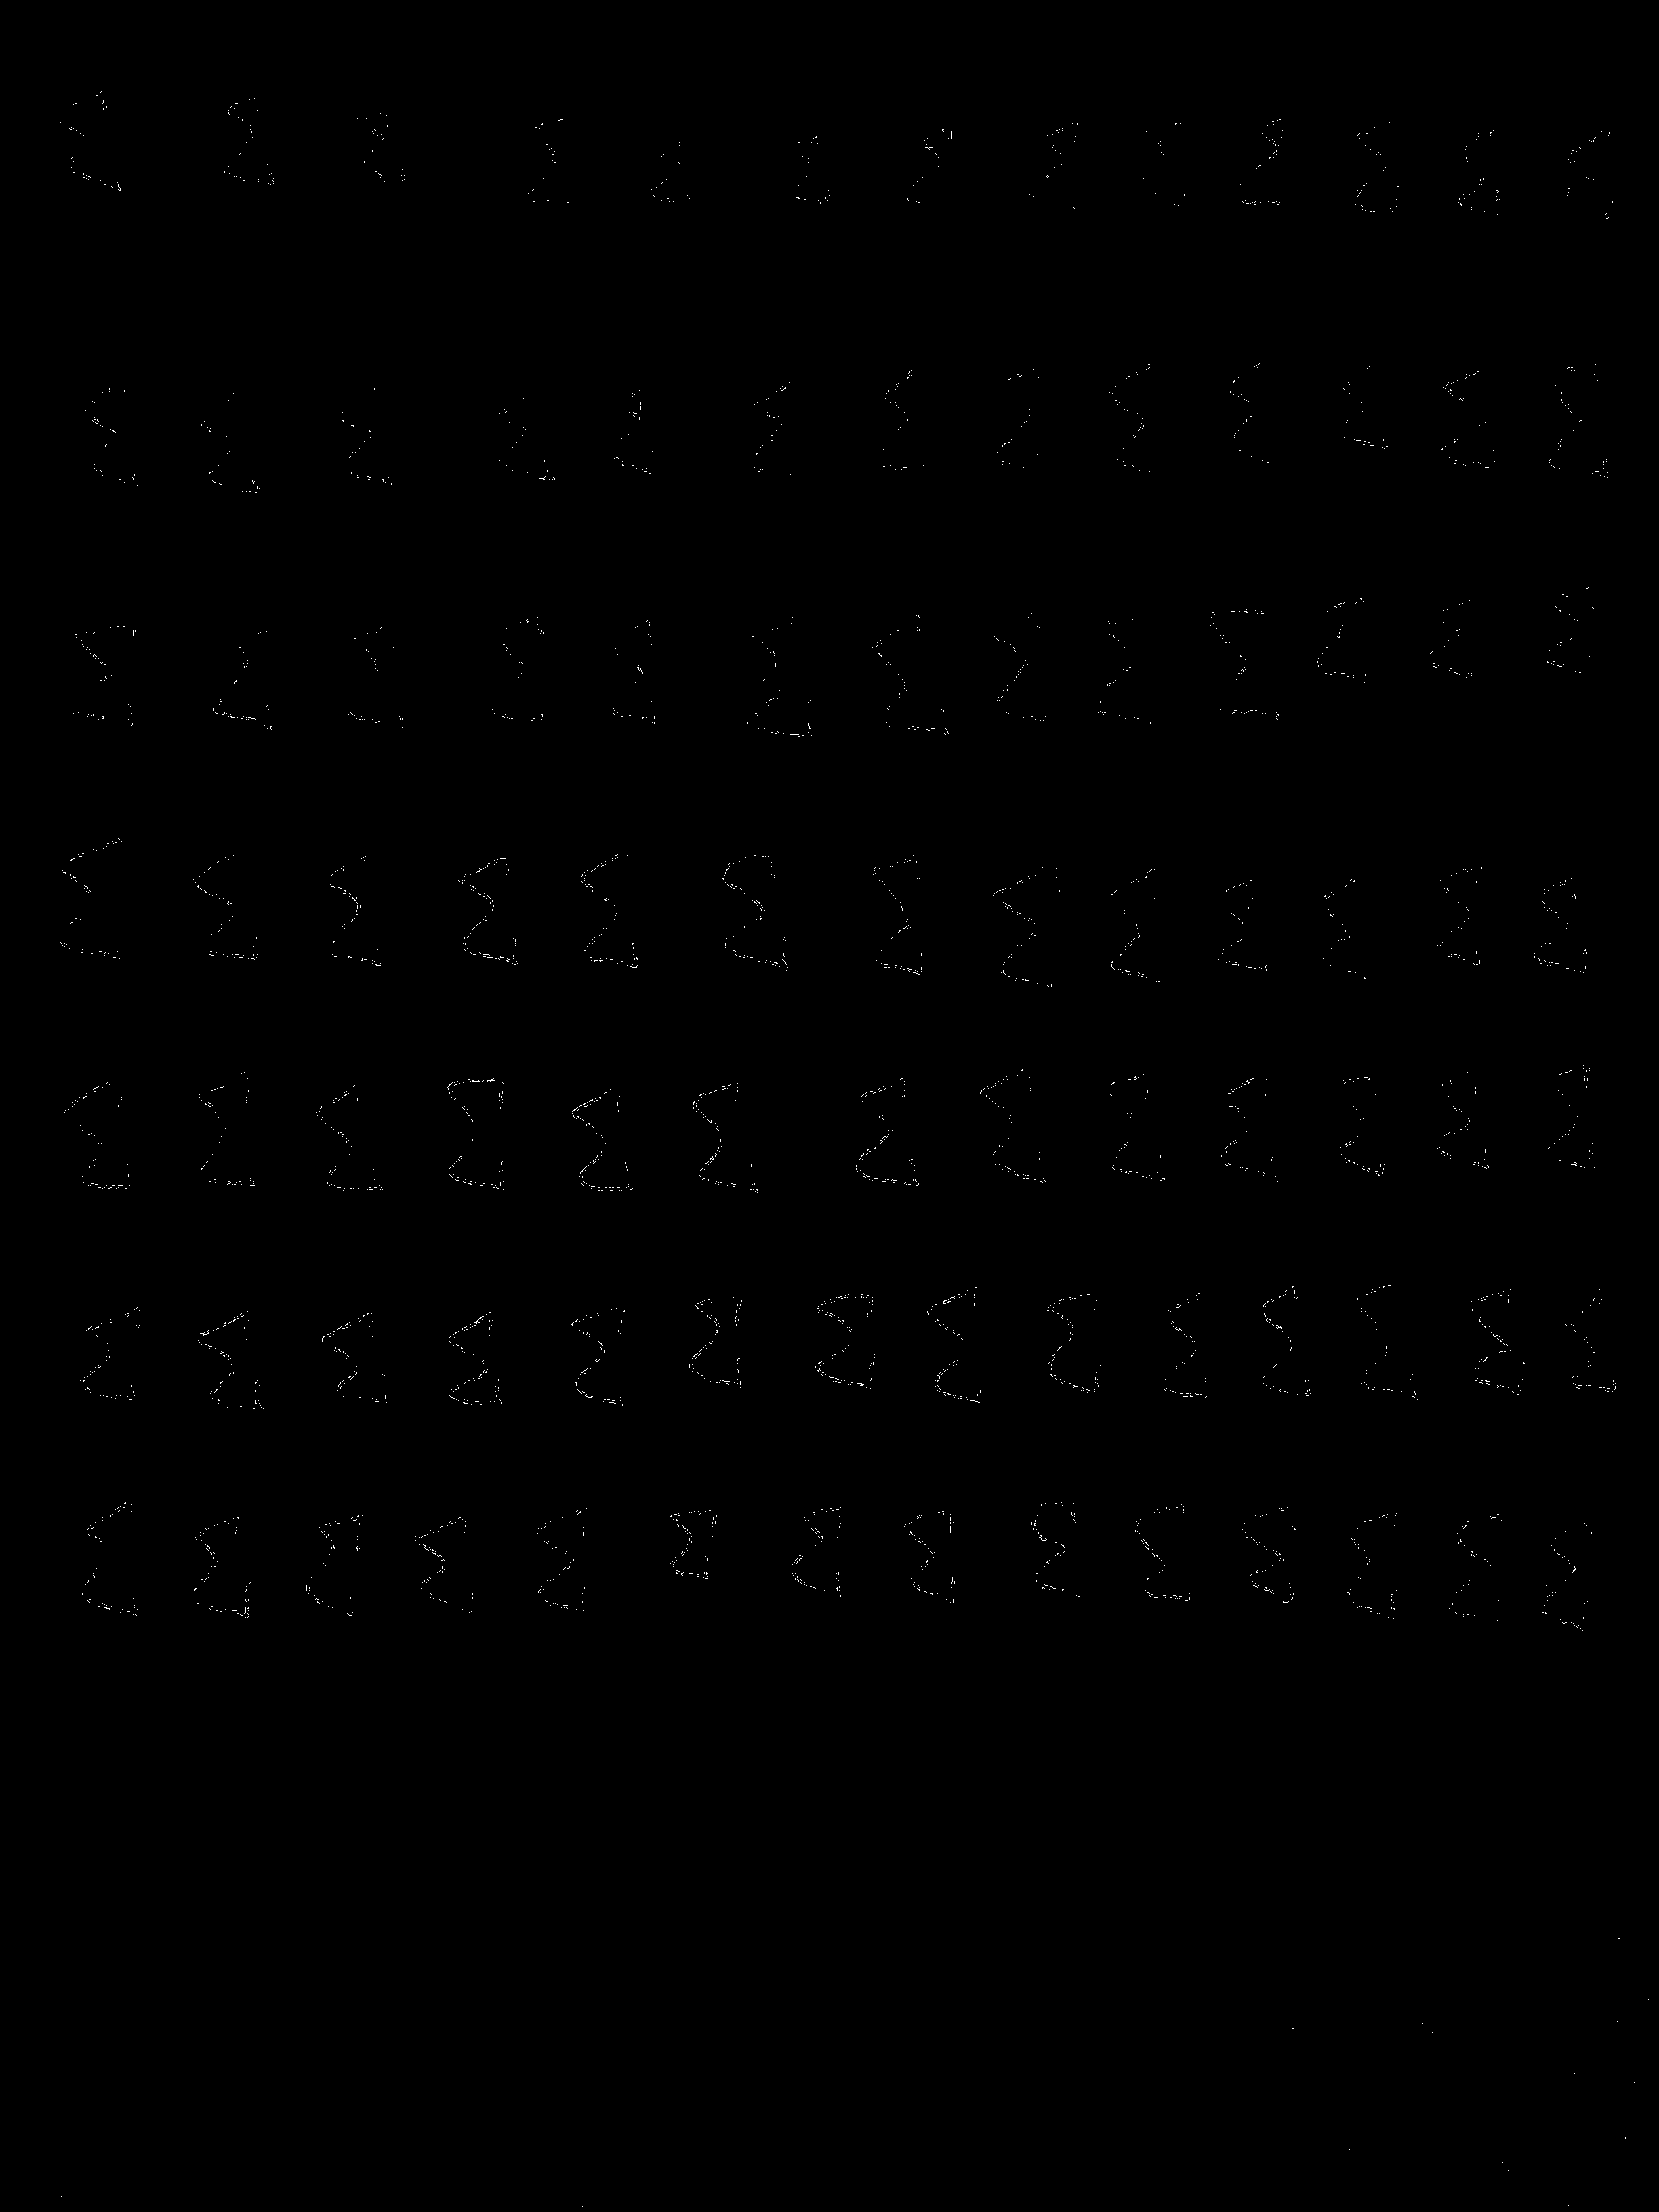

In [2]:
figure_img = im.open("imgs/macro_images/sigma.JPG")
figure_img = imo.grayscale(figure_img)
#figure_img = figure_img.resize((640,320), resample=im.NEAREST)
figure_img = figure_img.rotate(270, expand=True)
figure = np.asarray(figure_img) / 255
img = im.fromarray(np.uint8(figure * 255), 'L')

# All Edges
pixels = sliding_window_view(figure, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(edges,figure,out=edges)
np.greater_equal(edges, 0.04, out=edges) # contrast
img = im.fromarray(np.uint8(edges * 255), 'L')
display(img)

# Critical Edges
pixels = sliding_window_view(figure, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
crit_edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(crit_edges,figure,out=crit_edges)
np.greater_equal(crit_edges, 0.2, out=crit_edges) # contrast
img = im.fromarray(np.uint8(crit_edges * 255), 'L')
display(img)

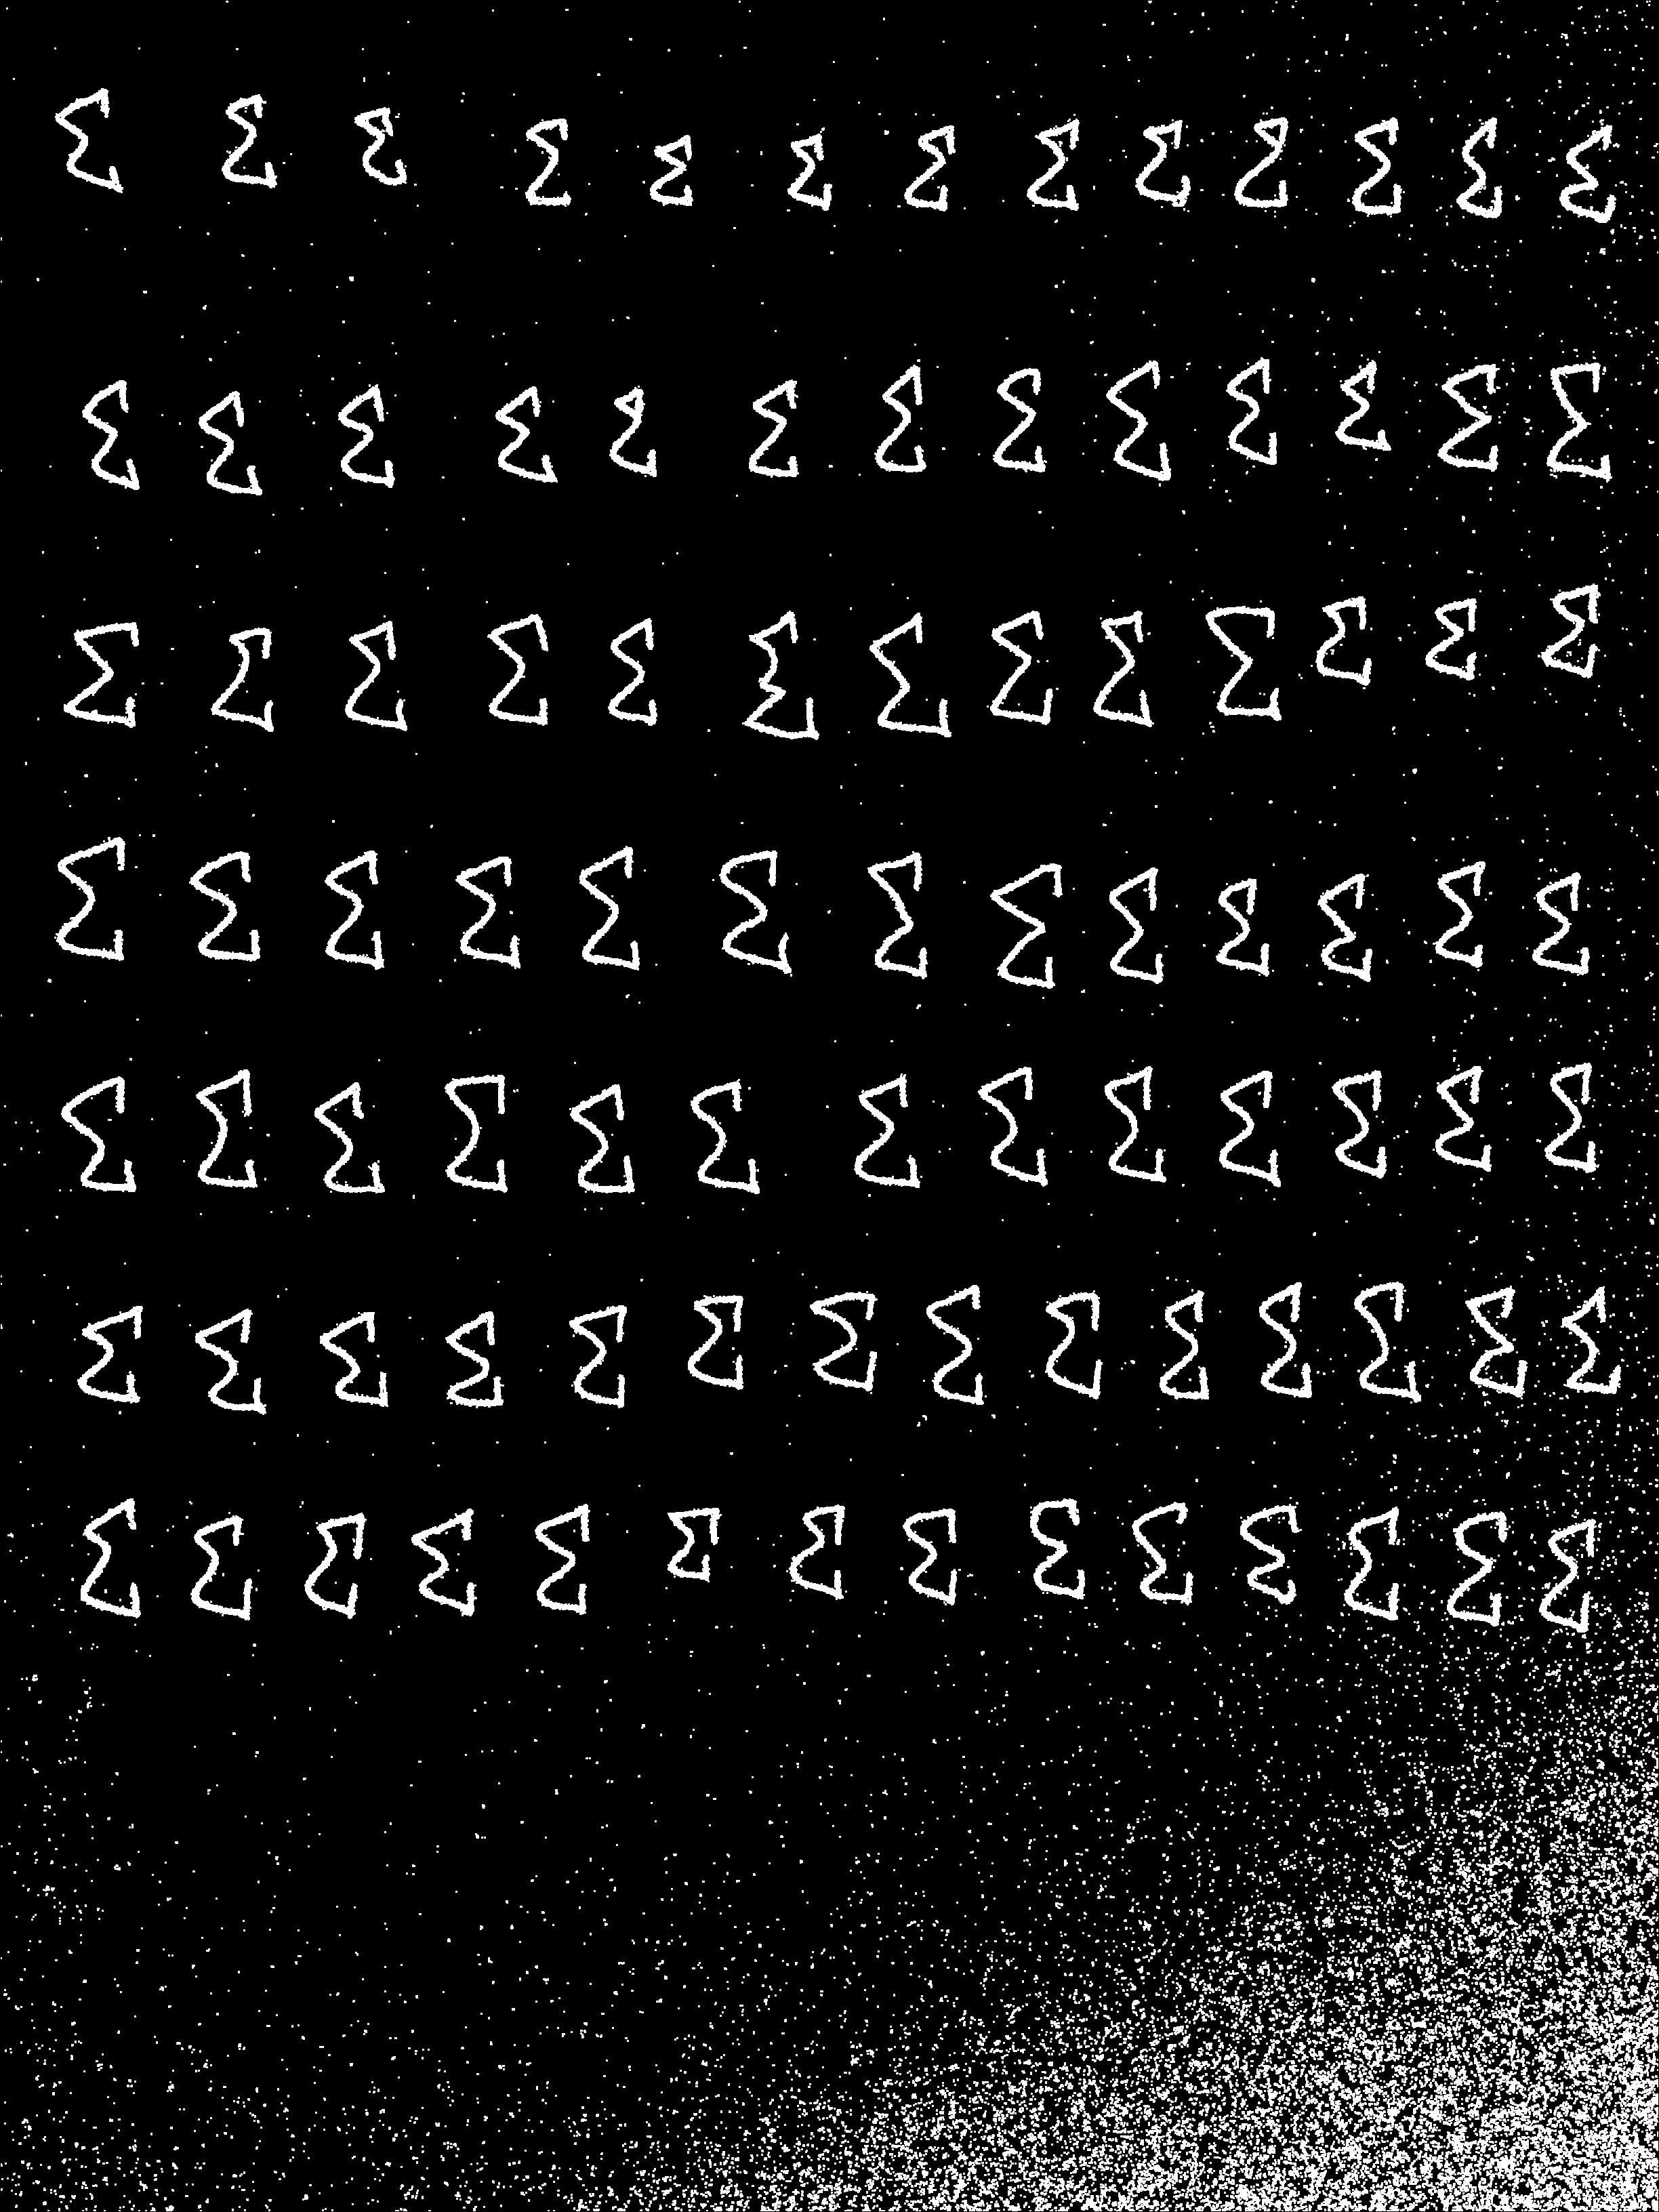

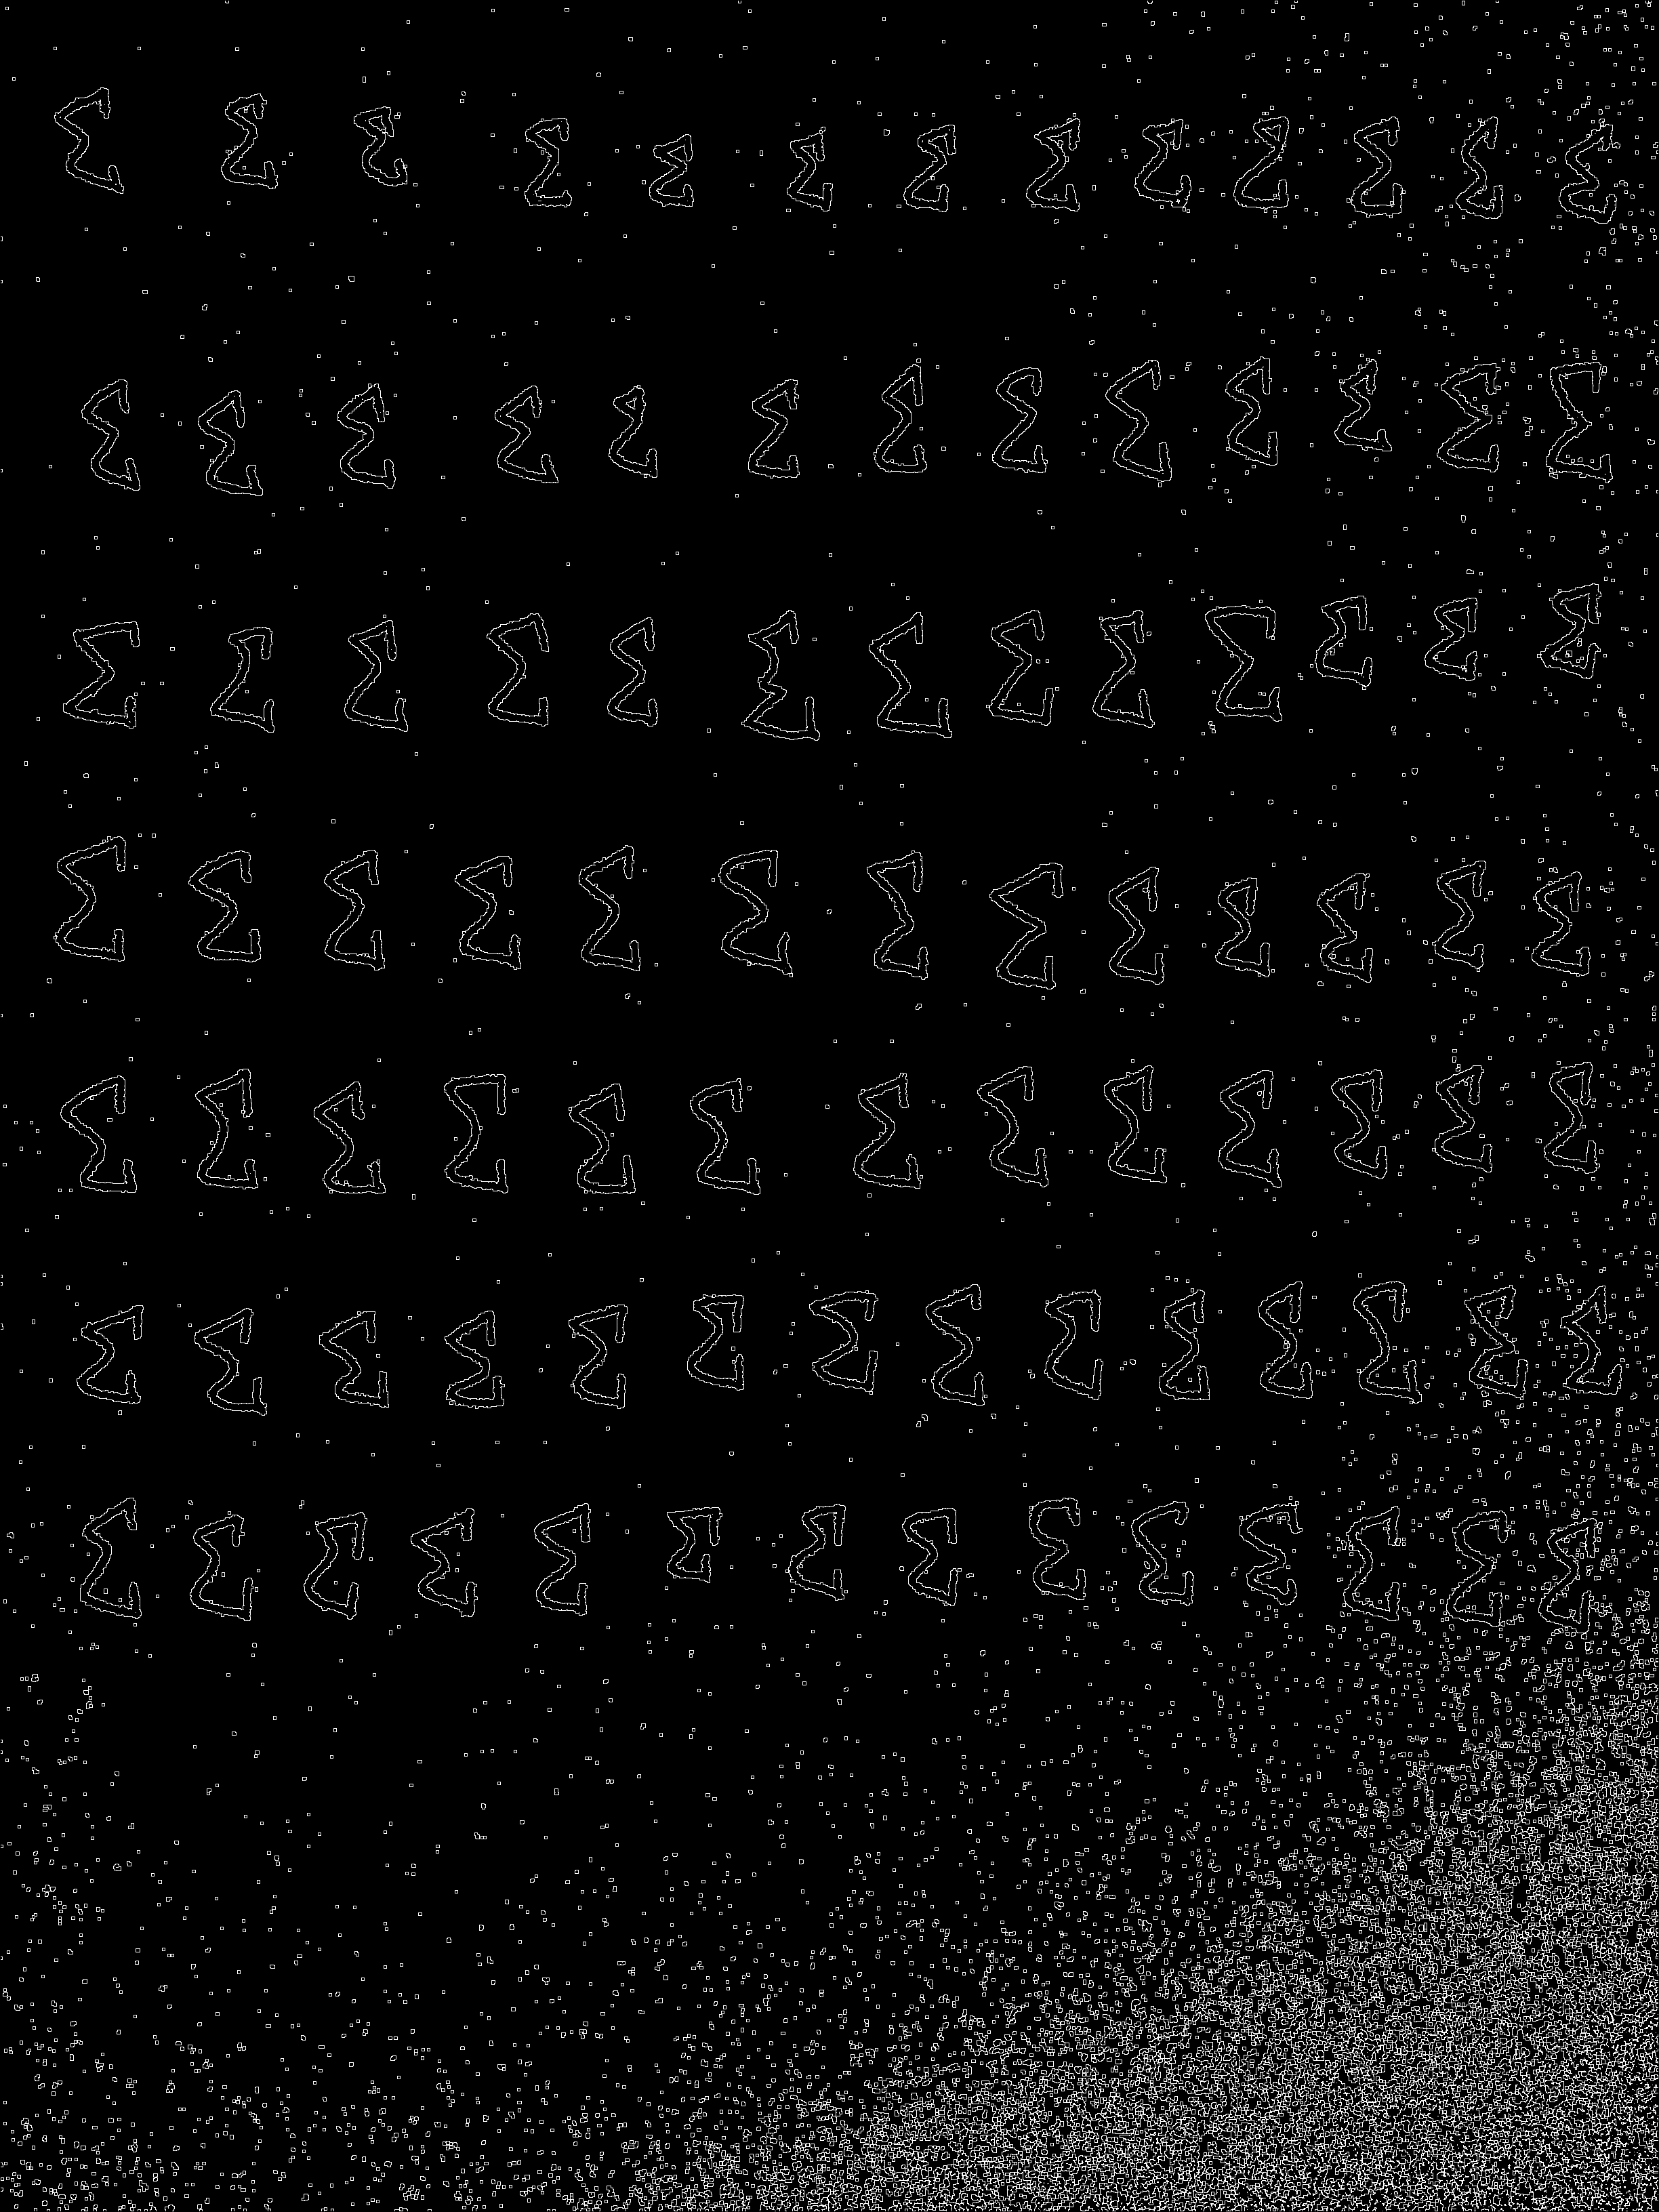

619274
318478


In [3]:
# BLUR
n = 3 #odd number
pixels = sliding_window_view(edges, (n,n))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
blur = np.reshape(pixels, (number_of_pixels,n**2)).max(axis=-1).reshape(shape)
blur = np.pad(blur, pad_width=1, mode='constant')
img = im.fromarray(np.uint8(blur * 255), 'L')
display(img)

# Critical Edges
pixels = sliding_window_view(blur, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
blur_edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(blur_edges,blur,out=blur_edges)
np.greater_equal(blur_edges, 0.01, out=blur_edges) # contrast
img = im.fromarray(np.uint8(blur_edges * 255), 'L')
display(img)
print(np.count_nonzero(blur == 1))
print(np.count_nonzero(blur_edges == 1))


In [4]:
def rot(old_coord):
    # Input: Last relative coordinate
    # Output: Next relative coordinate
    last = old_coord
    if   (last == (-1,-1)):
        return    (-1, 0)
    elif (last == (-1, 0)):
        return    (-1, 1)
    elif (last == (-1, 1)):
        return    (0, 1)
    elif (last == (0, 1)):
        return    (1, 1)
    elif (last == (1, 1)):
        return    (1, 0)
    elif (last == (1, 0)):
        return    (1, -1)
    elif (last == (1, -1)):
        return    (0, -1)
    else:
        return    (-1, -1)

In [5]:
def next_coord(coord, edges, last_coord):
    # Input: x,y coordinate of current pixel
    #        set of all edges
    #        last pixel seen
    # Output: next pixel in clockwise order
    (y,x) = coord
    (last_y, last_x) = last_coord
    rel_coord = (last_y - y, last_x - x)
    if (coord == (1600, 1796)):
        print("TRUE")
        print(rel_coord)
    for _ in range(8): # Was 7
        (diff_y, diff_x) = rot(rel_coord)
        if (coord == (1600, 1796)):
            print(diff_y, diff_x, tuple([y + diff_y, x + diff_x]) in edges)
        if (tuple([y + diff_y, x + diff_x]) in edges): #true if an edge
            return (y + diff_y, x + diff_x)
        rel_coord = (diff_y, diff_x)
    return None

In [6]:
def outline(start, edges):
    # Input: start edge, possible connecting edges
    # Output of the pixels on the border of image
    # in clockwise order
    (y,x) = start
    last = (0,0)
    (offset_y, offset_x) = (1, 0)
    last = (y+offset_y, x+offset_x)
    
    #ToDO Find the side that has white on it
        
    next_ = next_coord(start, edges, last) # wrong
    # better way to correct for next_
    
    
    last = start
    border = [start]
    border_set = set(start)
    while(True):
        if (next_ == None or next_ == start):#or next_ in border_set):
            break
        else:
            border.append(next_)
            border_set.add(next_)
            new_next = next_coord(next_, edges, last)
            last = next_
            next_ = new_next
    #print(border)      
    return border

In [7]:
def plot_borders(borders, size):
    print(size)
    temp = np.zeros(shape=size)
    for border in borders:
        for (y,x) in border:
            temp[y,x] = 255

    temp = temp.astype(np.uint8)
    img = im.fromarray(temp)
    display(img)

In [8]:
def plot_border(border, size):
    print(size)
    y_min = min(border)[0]
    x_min = min(border, key=lambda x:x[1])[1]
    temp = np.zeros(shape=size)
    for (y,x) in border:
        temp[y-y_min,x-x_min] = 255

    temp = temp.astype(np.uint8)
    img = im.fromarray(temp)
    display(img)

In [9]:
ii = np.where(crit_edges == 1)
crit_points = set(tuple(zip(*ii)))
ii = np.where(blur_edges == 1)
points = set(tuple(zip(*ii)))

print(len(crit_points))
print(len(points))
print(len(crit_points - points))
# NOTE ALL crit_points are in points

13970
318478
13970


In [10]:
# Move all crit_points up until they are in points
new = set()
while(len(crit_points) != 0):
    start = crit_points.pop()
    while(start not in points and start[0] > 0):
        start = (start[0]-1, start[1])
    if (start[0] > 0):
        new.add(start)
    
crit_points = new
print(len(crit_points))
print(len(points))
print(len(crit_points - points))

8986
318478
0


106
(3264, 2448)


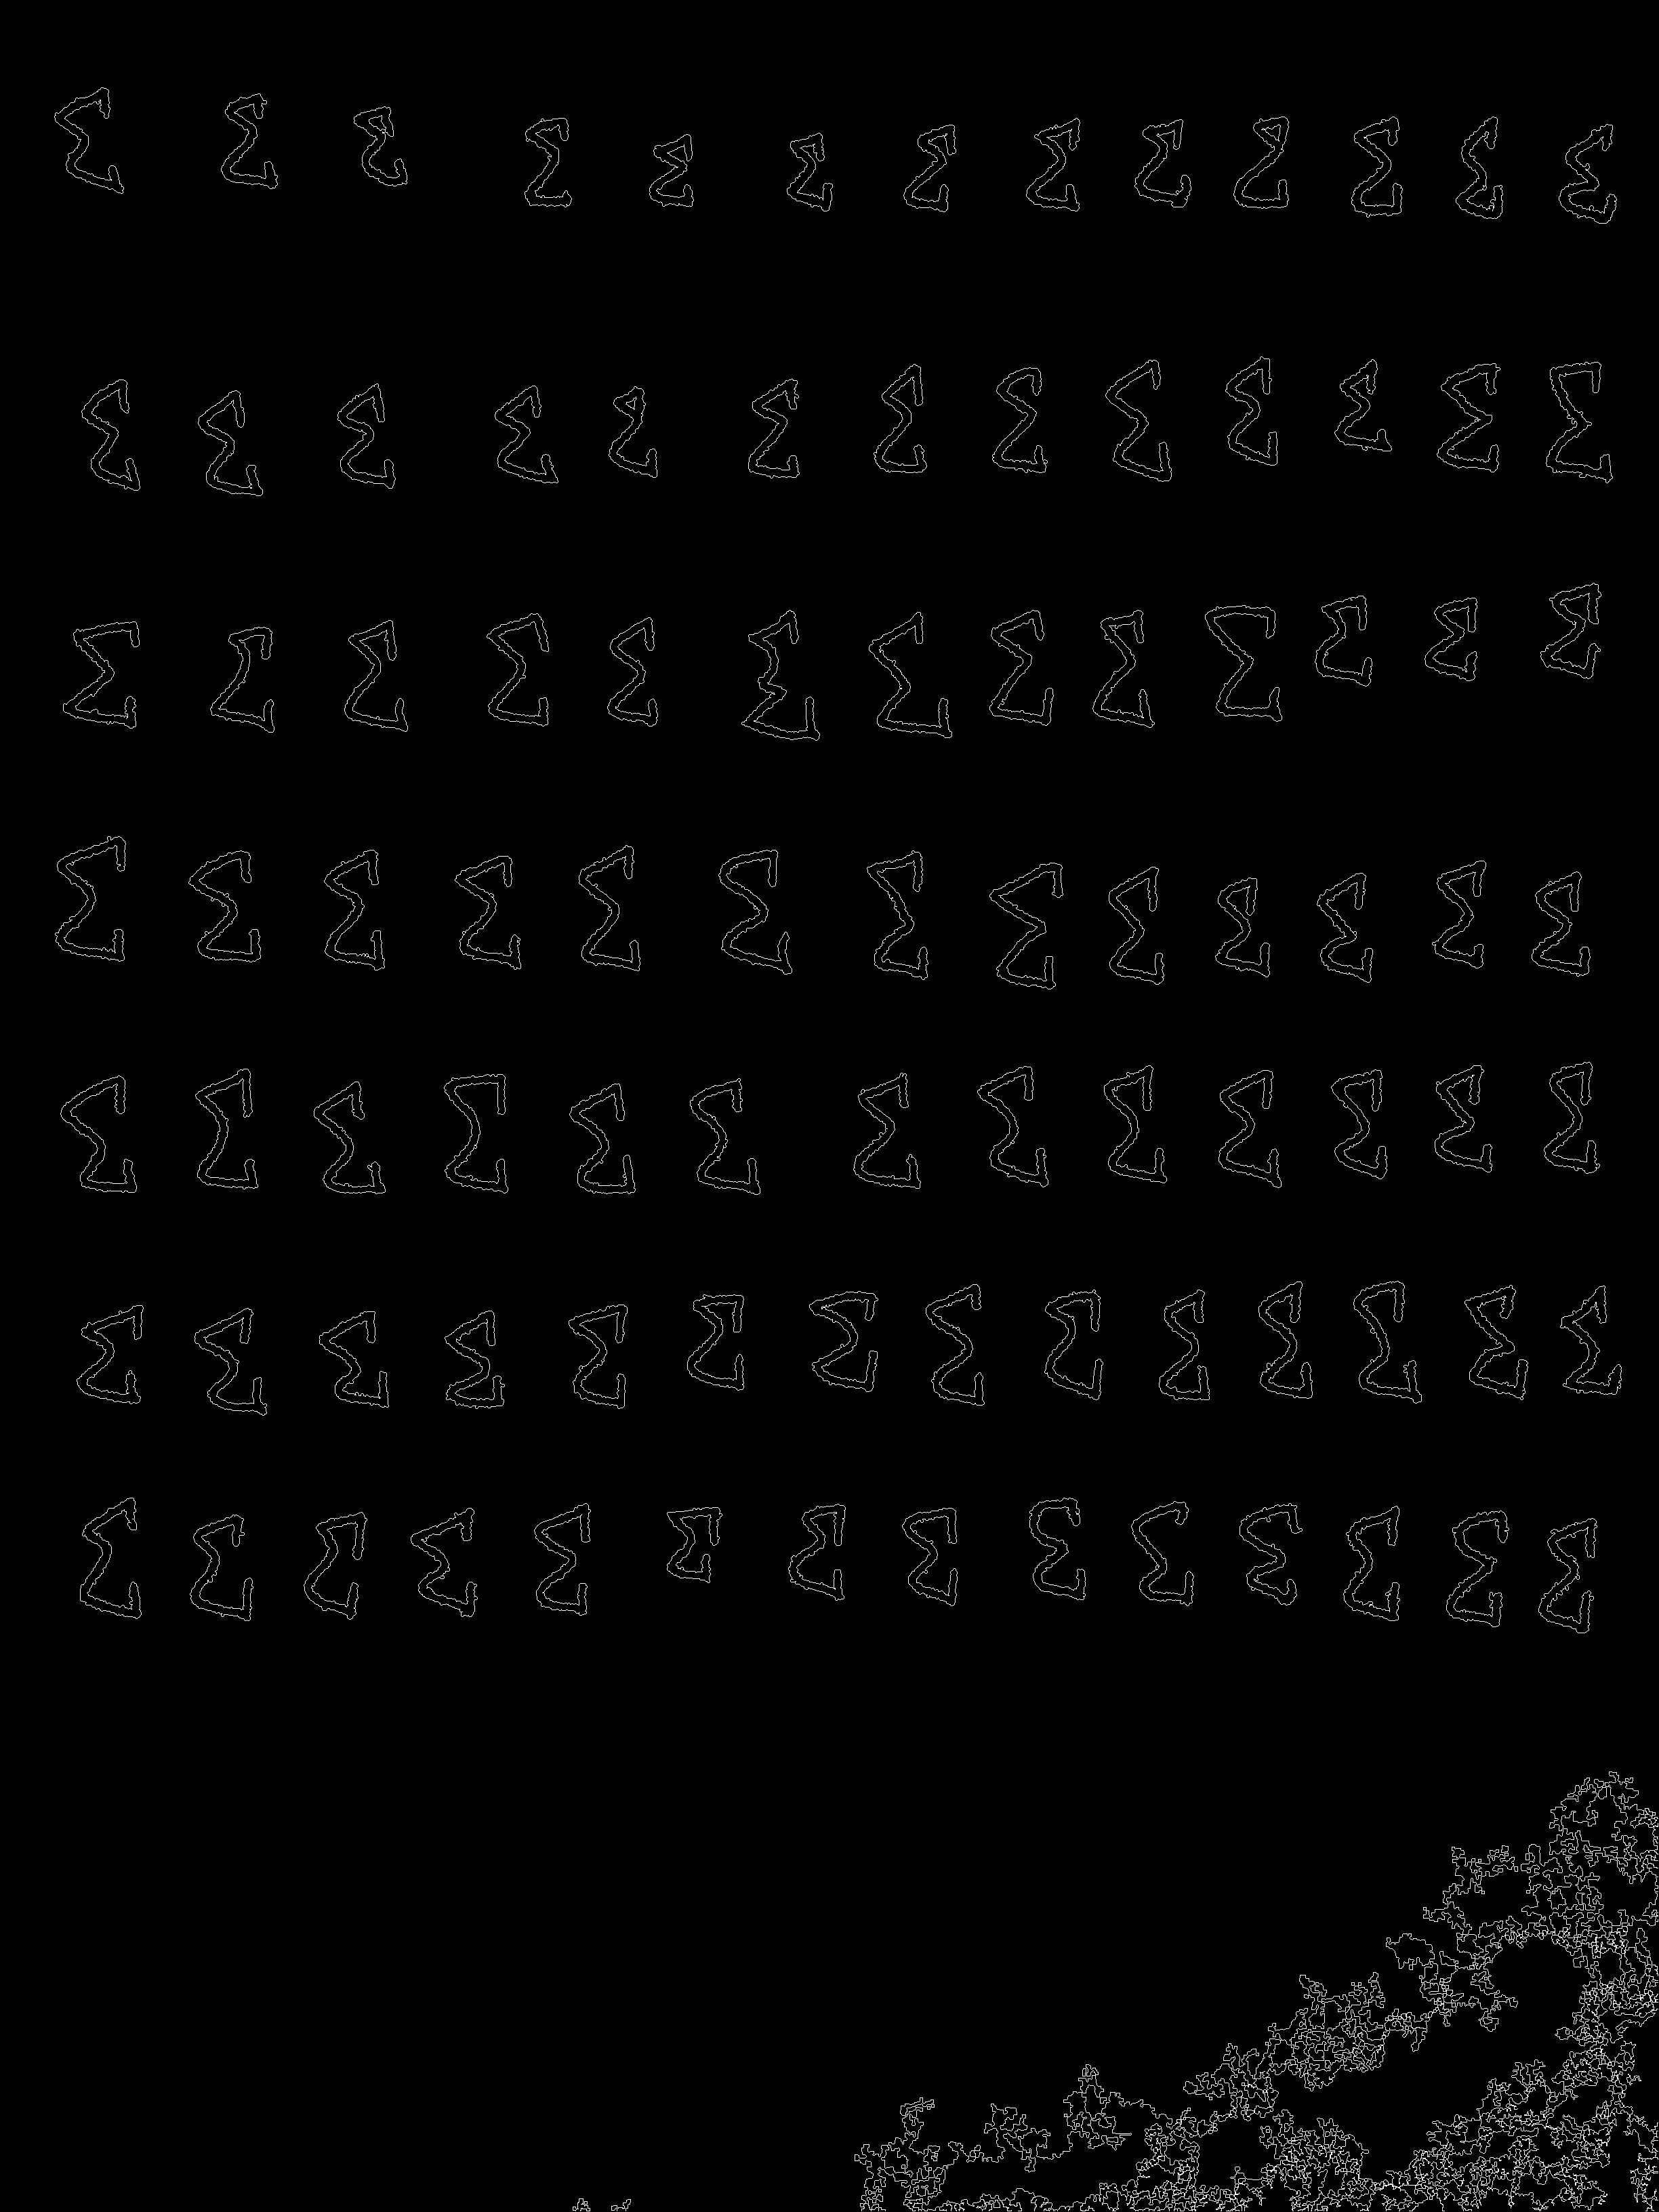

In [11]:
borders = []
while(len(crit_points) != 0): #!=
    start_edge_point = crit_points.pop()
    border = outline(start_edge_point, points)
    if (len(border) > 40):
        borders.append(border)
    temp = set(border)
    if ((1600, 1796) in temp):
        print("ERROR--", start_edge_point)
    points = points - temp
    crit_points = crit_points - temp
    
print(len(borders))
plot_borders(borders, crit_edges.shape)

In [12]:
temp = list(map(lambda x: len(x), borders))
temp.sort()
print(temp)

[54, 70, 85, 88, 102, 152, 167, 243, 483, 486, 536, 536, 573, 574, 601, 608, 615, 632, 635, 639, 639, 662, 662, 663, 666, 668, 681, 682, 691, 692, 698, 700, 703, 707, 715, 720, 720, 721, 721, 730, 734, 742, 744, 745, 747, 748, 758, 760, 761, 762, 767, 774, 774, 776, 778, 779, 782, 782, 784, 786, 790, 792, 795, 795, 800, 801, 802, 807, 809, 810, 810, 811, 812, 816, 821, 821, 822, 831, 834, 835, 837, 838, 838, 842, 850, 858, 865, 873, 881, 882, 883, 887, 889, 891, 899, 904, 905, 910, 917, 930, 932, 949, 1145, 1944, 11299, 28276]


In [13]:
idx = 7

138 278 326 409
start:  (156, 337) end:  (156, 338)
632 632
(141, 84)


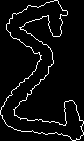

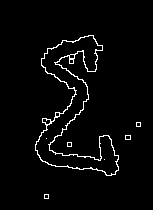

(3264, 2448)


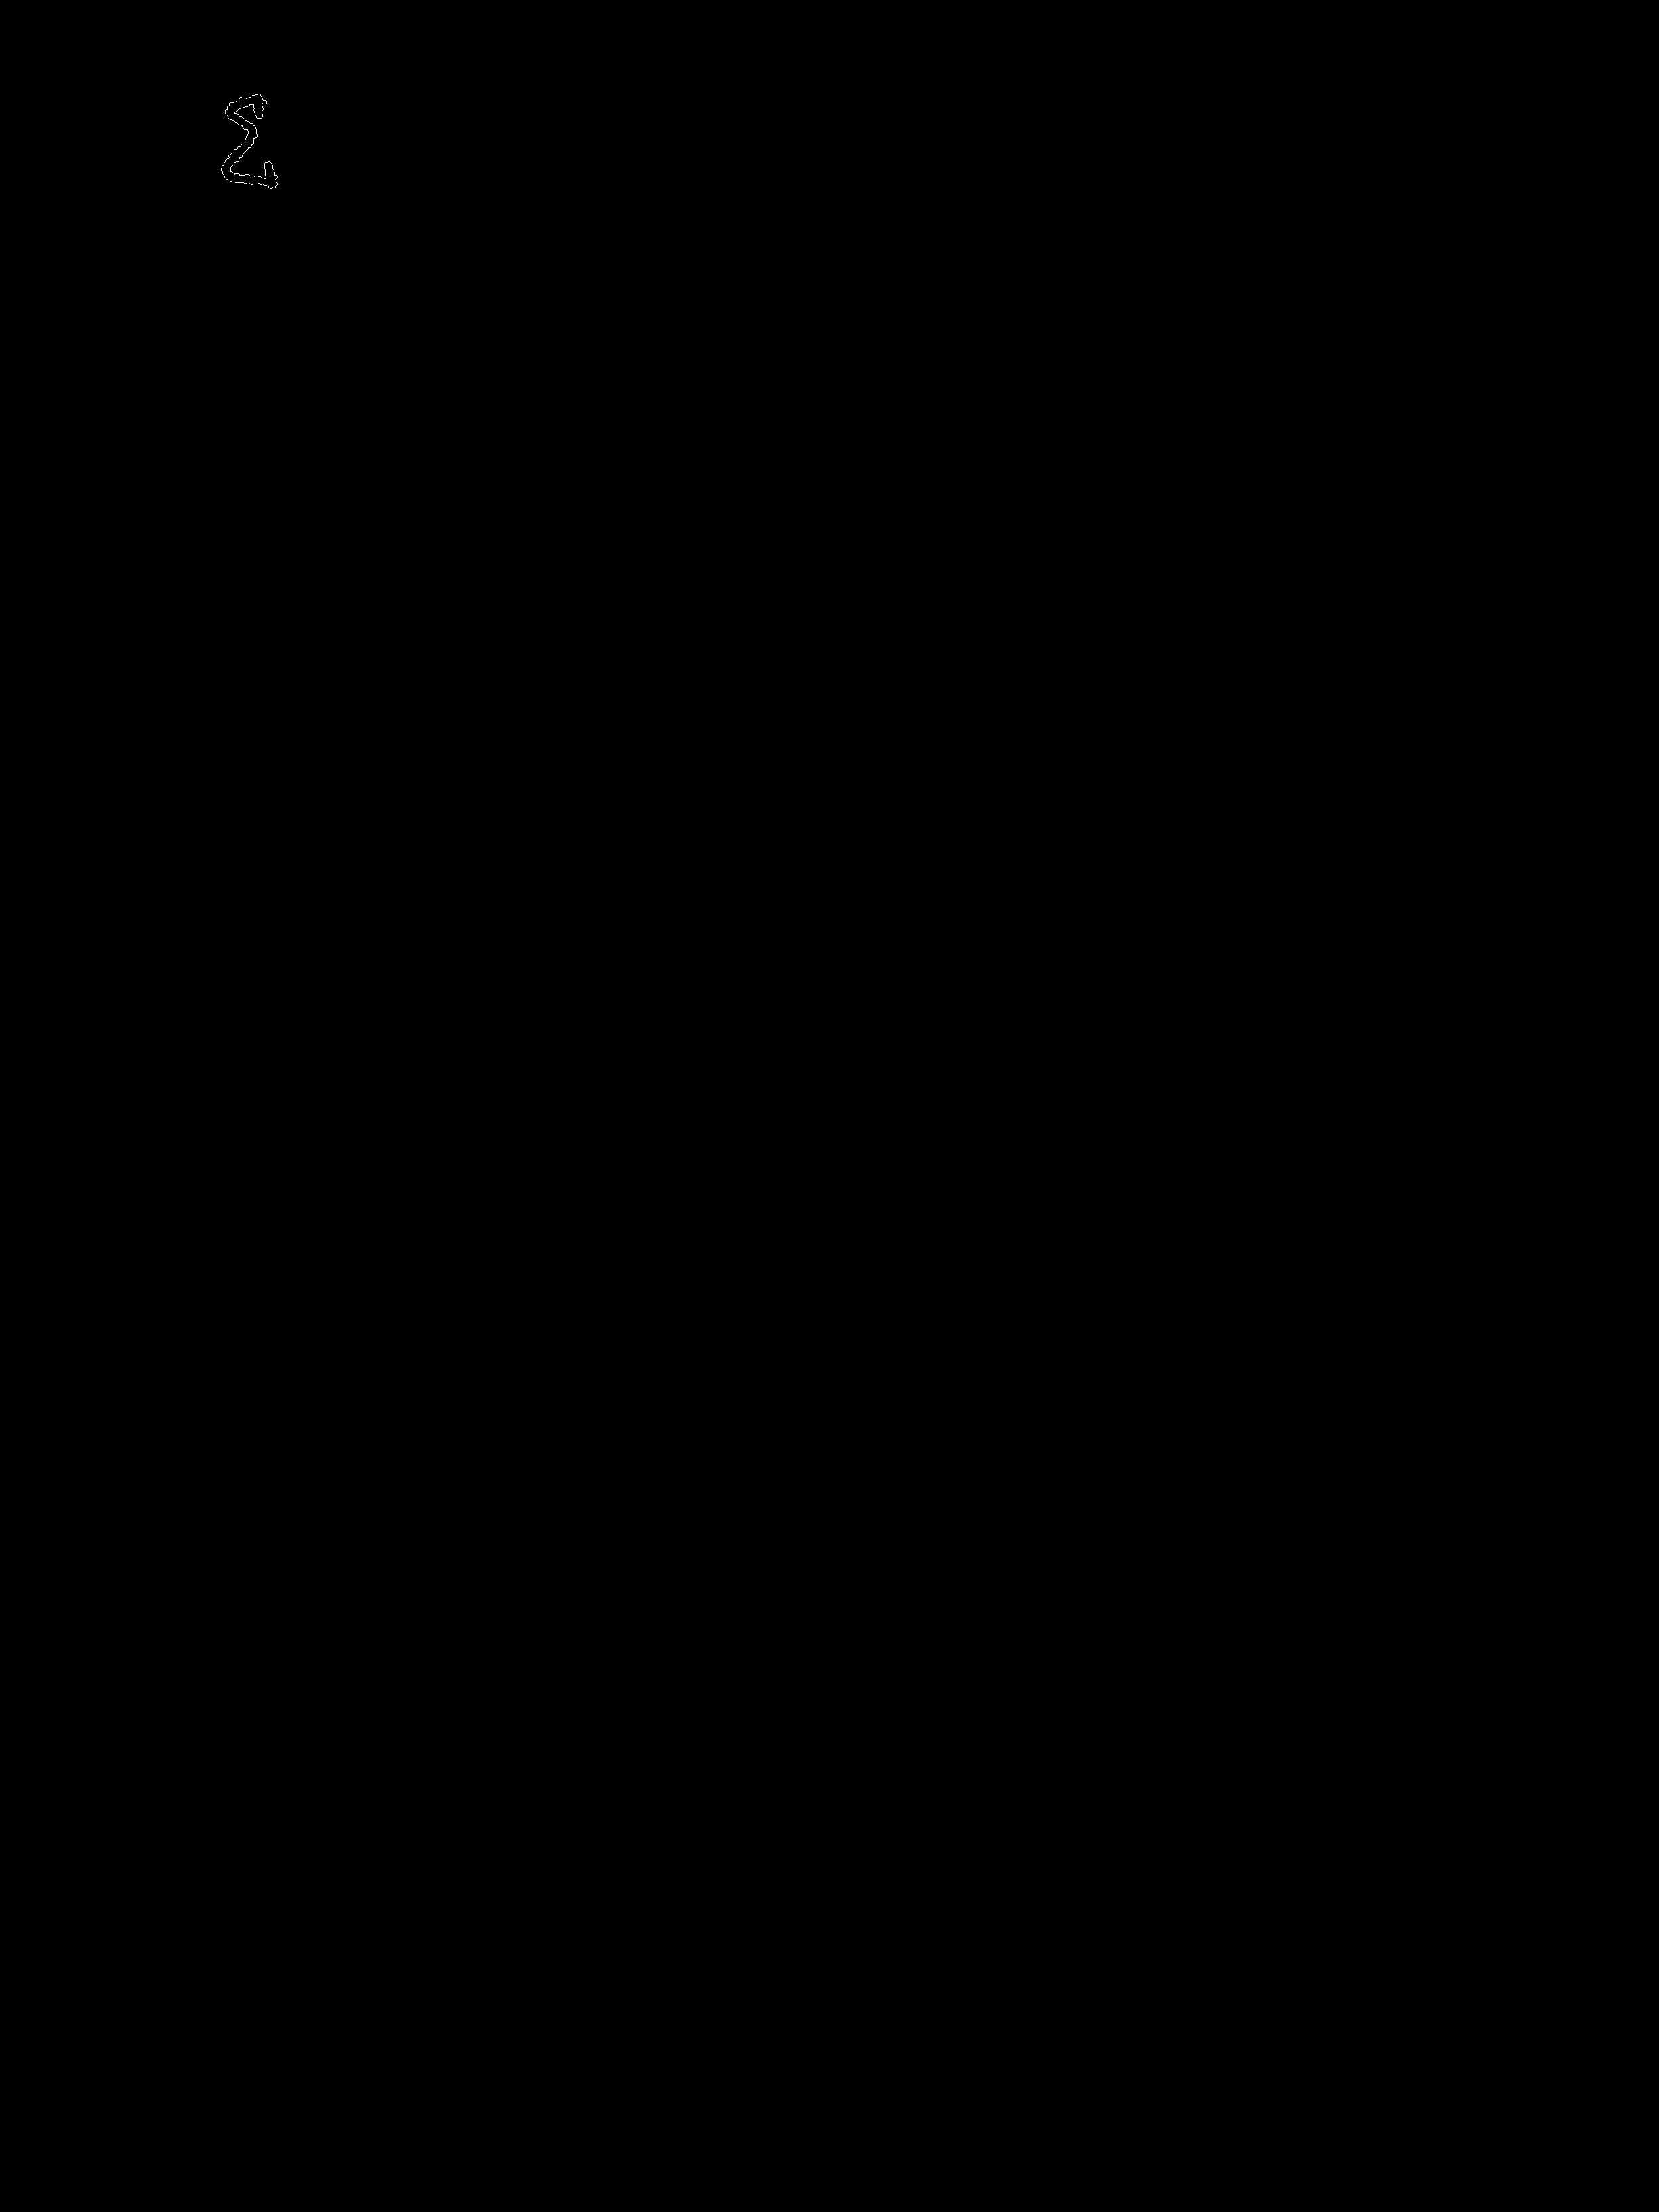

7


In [14]:
z = 35 #z for zoom
left_x = min(borders[idx])[0]
right_x = max(borders[idx])[0]
left_y = min(borders[idx], key=lambda t: t[1])[1]
right_y = max(borders[idx], key=lambda t:t[1])[1]
print(left_x, right_x, left_y, right_y)
print("start: ",borders[idx][0], "end: ",borders[idx][-1] )
print(len(borders[idx]), len(set(borders[idx])))
plot_border(borders[idx], (right_x - left_x + 1, right_y - left_y + 1))
img = im.fromarray(np.uint8(blur_edges[left_x-z:right_x+z, left_y-z:right_y+z] * 255), 'L')
display(img)
plot_borders([borders[idx]], crit_edges.shape)
#idx = idx + 1
print(idx)